## LangGraph로 Tool 사용하기 (ToolNode)

### 1. tool_list 정의 
- 단순 이름이 아님: [add, multiply]처럼 함수명을 괄호 없이 넣는 것은, 해당 함수의 메모리 주소와 로직 전체를 전달하는 것입니다.
- 일관성: bind_tools에 넣은 리스트와 ToolNode에 넣은 리스트가 동일해야 LLM이 요청한 도구를 ToolNode가 찾아낼 수 있습니다.

### 2. llm.bind_tools(tool_list) : 모델에게 주는 '설명서'
- 역할: LLM(두뇌)에게 사용 가능한 도구들의 목록과 사용법을 교육합니다.
- 전달 내용: 함수의 파이썬 코드 자체가 아니라, 함수의 이름, 설명(Docstring), 파라미터 규격을 JSON Schema 형태로 변환하여 모델 API에 전달합니다.
- 결과: LLM은 이 정보를 바탕으로 질문에 답변할지, 혹은 특정 도구를 호출할지(Reasoning) 결정할 수 있게 됩니다.

### 3. ToolNode(tool_list) : 실제 작업을 수행하는 '작업반장'
- 역할: LLM이 내린 도구 호출 지시(tool_calls)를 받아 실제 파이썬 함수를 실행하는 '실행전용 노드'
- 전달 내용: 함수 객체(Function Object) 그 자체를 들고 있습니다. (단순한 이름 문자열이 아니라 실행 가능한 코드 본체를 보유)
- 내부 동작
    - AIMessage에서 `tool_calls`를 읽음.
    - `tool_list`에서 이름이 일치하는 함수를 찾아 실행.
    - 결과값을 `ToolMessage`로 생성하여 반환 (ID 매칭 등 복잡한 과정을 자동화).

In [20]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')

In [21]:
from langchain_core.tools import tool

@tool 
def add(a: int, b:int) -> int:
    """숫자 a와 b를 더합니다.""" 
    return a + b

@tool
def multiply(a: int, b:int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [ ]:
add.invoke({'a': 4, 'b': 8})
multiply.invoke({'a': 4, 'b': 8})

In [22]:
from langgraph.prebuilt import ToolNode

#함수 객체 리스트 정의 
tool_list = [add, multiply]
#모델에 도구 설명서 전달 
llm_with_tools = small_llm.bind_tools(tool_list)
#함수 객체 리스트를 전달받아, llm의 도구 호출 지시에 따라 실제로 파이썬 함수를 실행하는 노드를 생성
tool_node = ToolNode(tool_list)

In [23]:
ai_message = llm_with_tools.invoke("3 더하기 5는?")

In [24]:
ai_message

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 83, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_084a28d6e8', 'id': 'chatcmpl-DCdWezh6hqc9tFCKk6dz1MxGfre6j', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c8db9-17e4-7c22-9b61-d28e121fbf1a-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'call_dhrLOxKLokqK9ZPSfxPwRVUz', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 83, 'output_tokens': 17, 'total_tokens': 100, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [25]:
ai_message.tool_calls # 리스트 

[{'name': 'add',
  'args': {'a': 3, 'b': 5},
  'id': 'call_dhrLOxKLokqK9ZPSfxPwRVUz',
  'type': 'tool_call'}]

## LangGraph로 간단한 에이전트 만들기 

### 1. MessagesState란 무엇인가요?
- 보통 AI 에이전트 그래프를 만들 때, 가장 핵심이 되는 데이터는 **대화 기록(메시지 리스트)**
-  랭그래프 개발자들이 State 내에 messages: Annotated[list, add_messages] 같은 코드를 반복해서 짜는 걸 보고, "그냥 이거 하나로 합쳐서 미리 제공하자!" 해서 만든 것이 바로 MessagesState입니다.
    
### 2. add_messages의 기능 
- 덮어쓰기가 아닌 **추가**: 일반적인 딕셔너리는 messages에 새 값을 넣으면 이전 내용이 지워지지만, MessagesState는 새로운 메시지가 들어오면 기존 리스트 뒤에 차곡차곡 쌓아줍니다(Append).
- ID 기반 **업데이트**: 만약 같은 ID를 가진 메시지가 들어오면, 새로 추가하는 게 아니라 기존 메시지를 수정(Update)해주기도 합니다.


In [ ]:
# MessagesState 내부 정의 
'''
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
'''

In [26]:
from langgraph.graph import MessagesState, StateGraph

# graph_builder = StateGraph(AgentState)
graph_builder = StateGraph(MessagesState)

In [27]:
def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지 (AIMessage)를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    # 상태에서 메시지 리스트를 추출합니다.
    messages = state['messages']
    
    # LLM과 도구를 사용하여 메시지를 처리하고 응답을 생성합니다.
    response = llm_with_tools.invoke(messages)
    
    # 응답 메시지를 새로운 상태로 반환합니다.
    return {'messages': [response]}

In [28]:
from typing import Literal
from langgraph.graph import END

def should_continue(state: MessagesState) -> Literal['tools', END]:
    """
    주어진 메시지 상태를 기반으로 에이전트가 계속 진행할지 여부를 결정합니다.

    Args:
        state (MessagesState): `state`를 포함하는 객체.

    Returns:
        Literal['tools', END]: 도구를 사용해야 하면 `tools`를 리턴하고, 
        답변할 준비가 되었다면 END를 반환해서 프로세스를 종료합니다.
    """
    # 상태에서 메시지 리스트를 추출합니다.
    messages = state['messages']
    
    # 마지막 AI 응답 메시지를 가져옵니다.
    last_ai_message = messages[-1]
    
    # 마지막 AI 메시지가 도구 호출을 포함하고 있는지 확인합니다.
    if last_ai_message.tool_calls:
        # 도구 호출이 있으면 'tools'를 반환합니다.
        return 'tools'
    
    # 도구 호출이 없으면 END를 반환하여 프로세스를 종료합니다.
    return END

In [29]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [ ]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')

graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', END]
)

graph_builder.add_edge('tools', 'agent')

In [31]:

graph = graph_builder.compile()

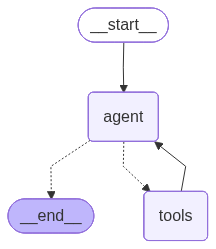

In [32]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:

from langchain_core.messages import HumanMessage
user_message = HumanMessage('3에다 5를 더하고 거기에 8을 곱하면?') 

graph.invoke({"messages": [user_message]})

{'messages': [HumanMessage(content='3에다 5를 더하고 거기에 8을 곱하면?', additional_kwargs={}, response_metadata={}, id='87dd6c1a-9f46-45dd-9837-b1479149a476'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 93, 'total_tokens': 143, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_084a28d6e8', 'id': 'chatcmpl-DCdbM6Dx3X22xgc11nDKAmsWOlX3G', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c8dbd-8d67-7921-8d25-7f772df4cce3-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'call_RbVc1W3fc9qtH5Nr4EqWZXE0', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 5, 'b': 8}, 'id': 'call_3ODHYIbuZymCU6B3DytZF0i

### should_continue를 대체하는 tools_condition
- 직접 정의한 should_continue: 마지막 AI 응답 메시지에 tool_calls가 있으면 "tools" 노드로, 없으면 END로 보냄 
- 이 패턴은 랭그래프에서 가장 많이 쓰이는 패턴이기 때문에 **tools_condition**이라는 이름으로 라이브러리에 내장되어 있음

### tools_condition의 장점 
- **코드 간결화**: should_continue와 내부 로직이 거의 일치하며 매번 동일한 노드를 만들 필요 없음
- **타입 힌트 생략**: add_conditional_edges의 파라미터에 ['tools', END] 같은 이동 가능한 경로 리스트를 굳이 명시하지 않아도, tools_condition 자체에 그 정보가 포함되어 있어 랭그래프가 알아서 경로를 찾아냅니다.
- **유연한 노드 이름**: tools_condition은 기본적으로 상태를 확인해서 도구가 필요하면 "tools"라는 이름의 노드로 가도록 설계되어 있습니다.
- **더 꼼꼼한 체크**: tools_condition은 마지막 메시지가 없을 때나, AI 메시지가 아닐 때 등 예외적인 상황에 대한 방어 코드가 조금 더 들어가 있어서 조금 더 안전해요.

In [ ]:
# 직접 정의한 should_continue 노드대신 langgraph에서 제공하는 tools_condition을 사용해도 동일하게 작동한다. 
'''
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition

graph_builder.add_edge(START, 'agent')

graph_builder.add_conditional_edges(
    'agent',
    tools_condition,
)

graph_builder.add_edge('tools', 'agent')
'''